# 1. Import Dependencies

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch 
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from scipy.stats import boxcox


# 2. Load Datasets

In [3]:
# Load datasets
combined_stock_data = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\combined_stock_data.csv')
sentiment_data = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\combined_sentiment_data.csv')
macroeconomic_data = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\macroeconomic_data.csv')
preprocessed_stock_data = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\preprocessed_stock_data.csv')
stock_data_with_indicators = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\stock_data_with_indicators.csv')

# 3. Combine Datasets

In [4]:
# Combine datasets
combined_data = pd.merge(combined_stock_data, sentiment_data, on=['Date', 'Symbol'], how='left')
combined_data = pd.merge(combined_data, macroeconomic_data, on='Date', how='left')
combined_data = pd.merge(combined_data, preprocessed_stock_data, on=['Date', 'Symbol'], how='left')
combined_data = pd.merge(combined_data, stock_data_with_indicators, on=['Date', 'Symbol'], how='left')
combined_data.fillna(0, inplace=True)


# 4. EDA

In [5]:
print("Basic Statistics:\n", combined_data.describe())
print("Missing Values:\n", combined_data.isna().sum())

Basic Statistics:
              Open_x        High_x         Low_x       Close_x      Volume_x  \
count  50016.000000  50016.000000  50016.000000  50016.000000  5.001600e+04   
mean      60.963684     61.780752     60.130048     60.976462  2.132240e+08   
std      106.964668    108.392722    105.489604    106.969889  3.249996e+08   
min        0.032106      0.032563      0.030496      0.031191  0.000000e+00   
25%        1.589125      1.618820      1.556160      1.590872  3.709906e+07   
50%       15.416350     15.631000     15.192700     15.402500  9.287317e+07   
75%       63.295000     63.985425     62.600750     63.344000  2.452743e+08   
max      765.760000    773.000000    761.120000    772.070000  1.010038e+10   

       Sentiment_x        PPIACO      CPIAUCSL        UNRATE           GDP  \
count      50016.0  50016.000000  50016.000000  50016.000000  50016.000000   
mean           0.0      2.711686      3.327611      0.060013    281.903724   
std            0.0     24.361473   

In [6]:
# Drop non-numeric columns for heatmap calculation
numeric_data = combined_data.drop(columns=['Date', 'Symbol'])

In [7]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(numeric_data), columns=numeric_data.columns)

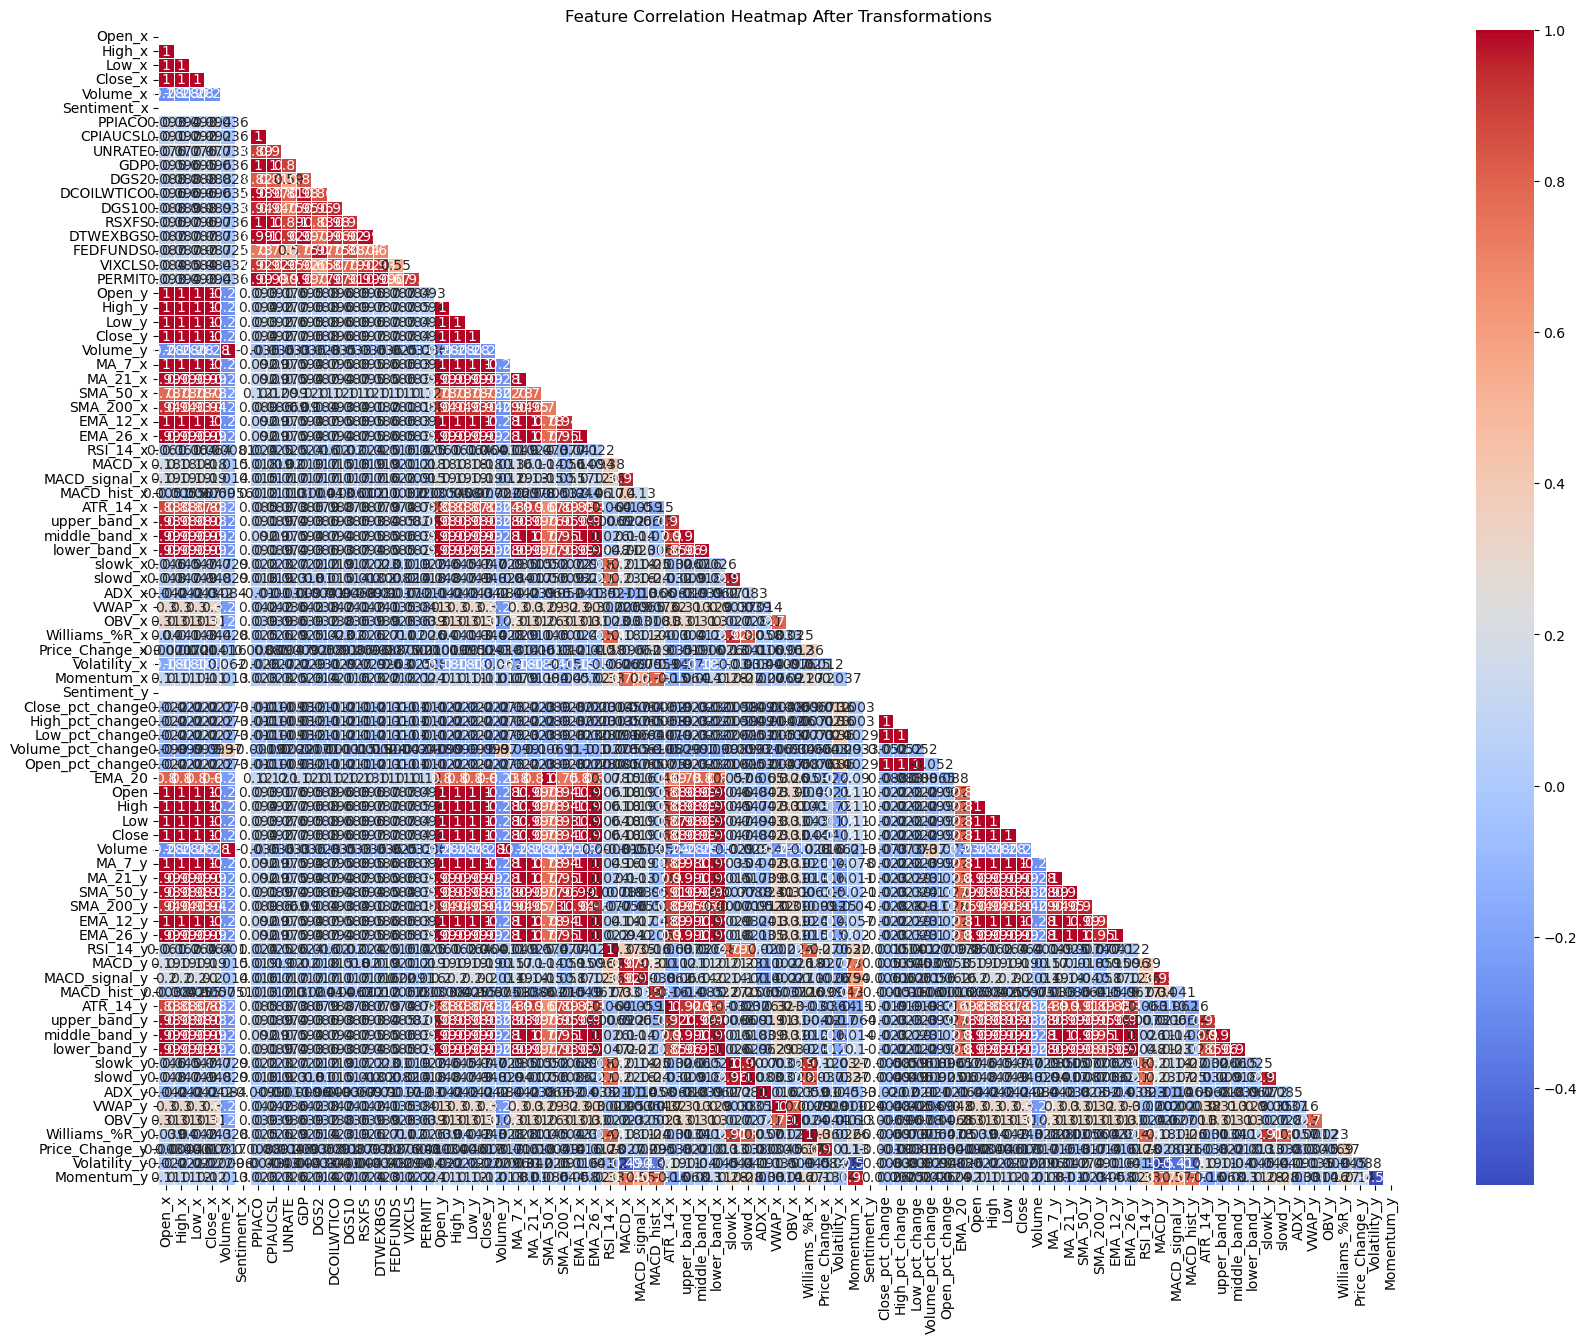

In [ ]:
# Correlation Heatmap 
plt.figure(figsize=(20, 15))
corr_matrix = scaled_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap After Transformations')
plt.show()

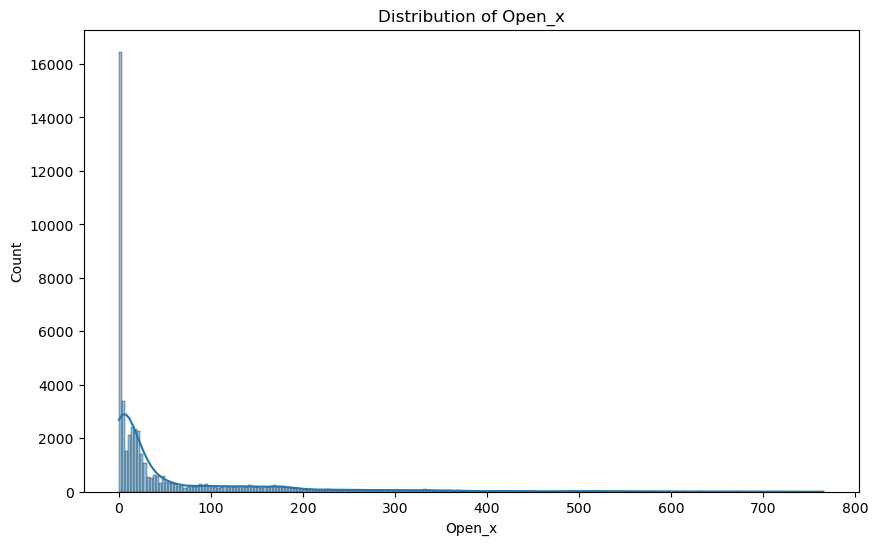

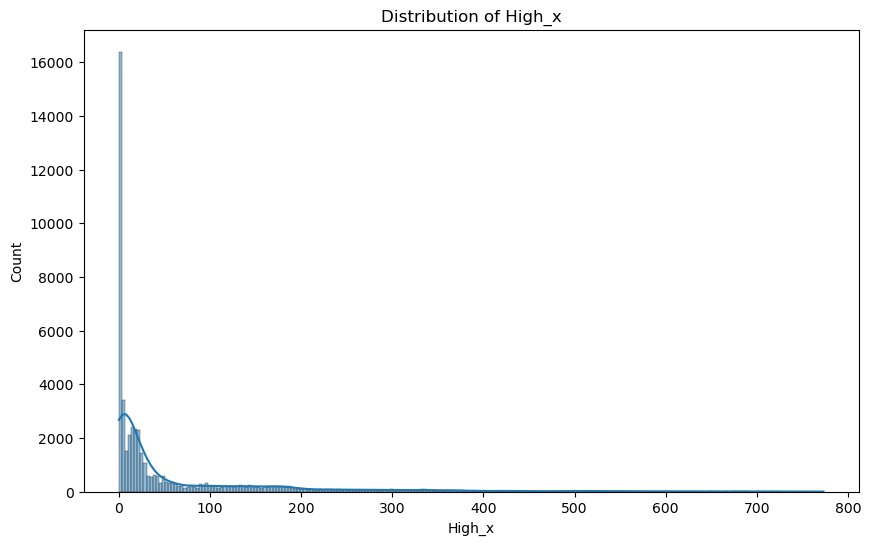

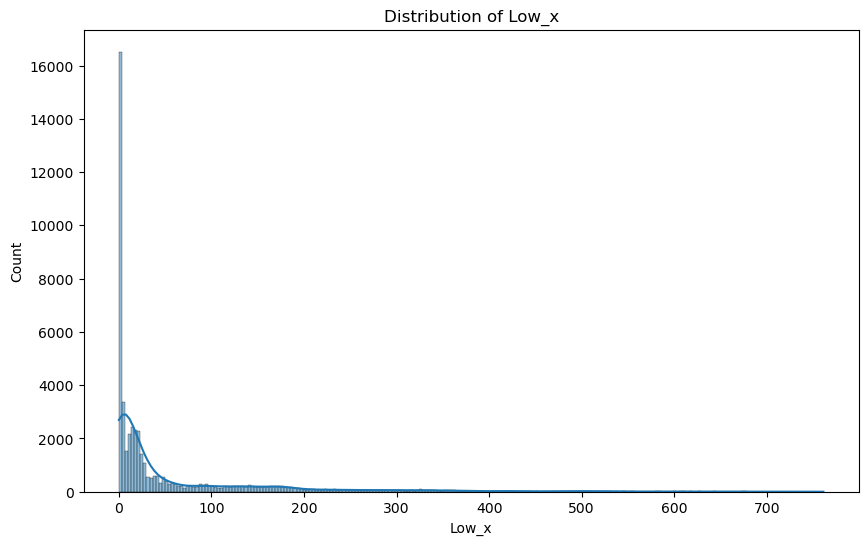

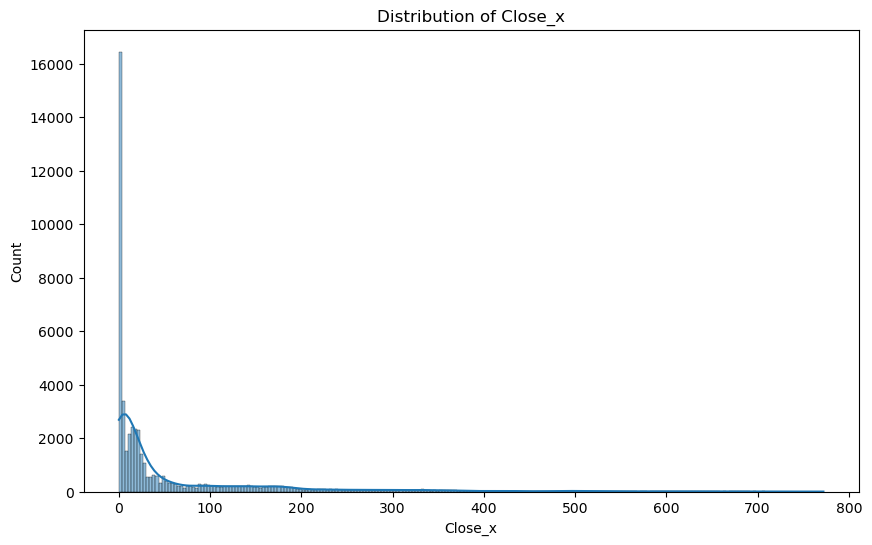

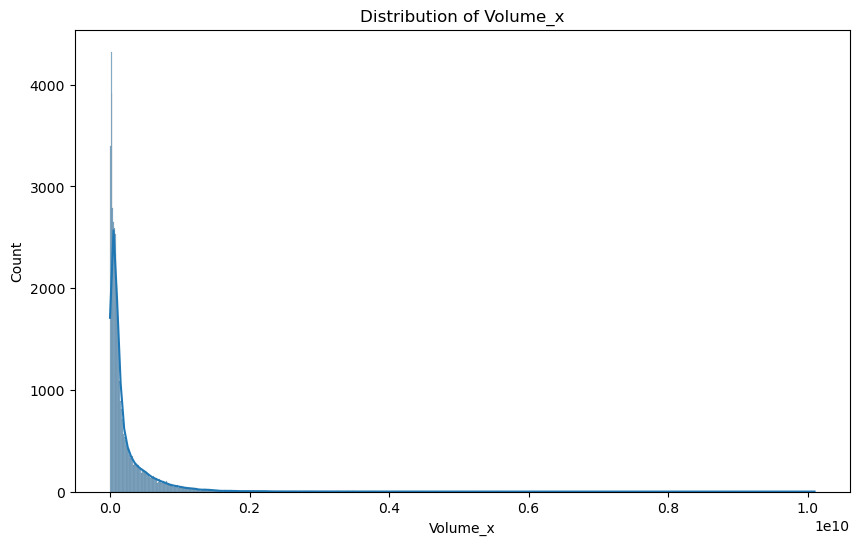

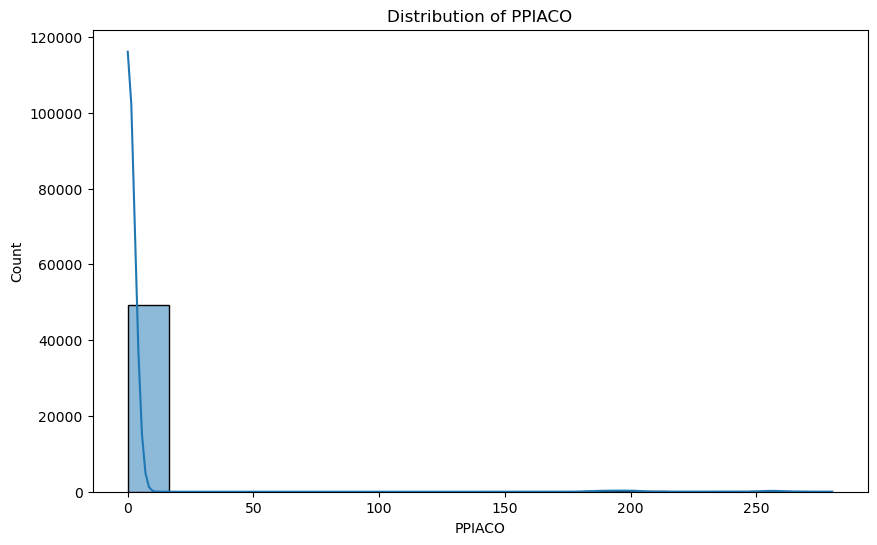

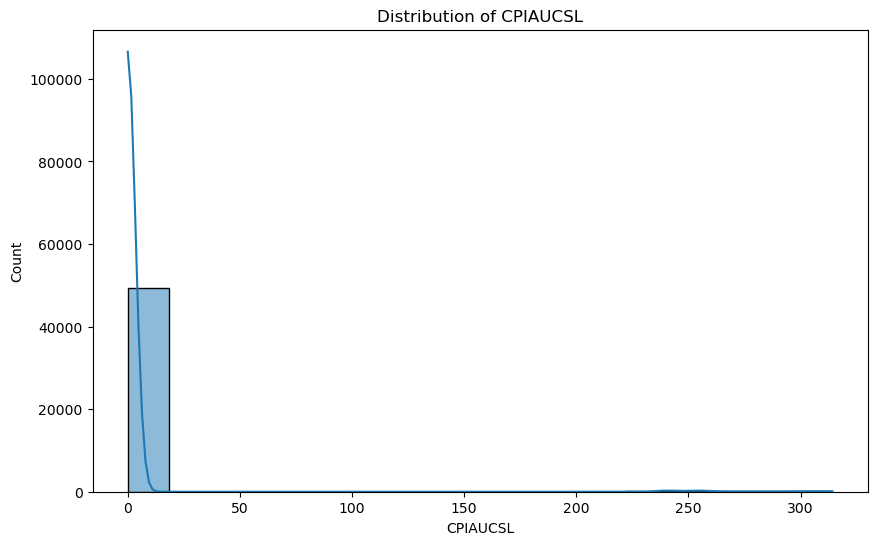

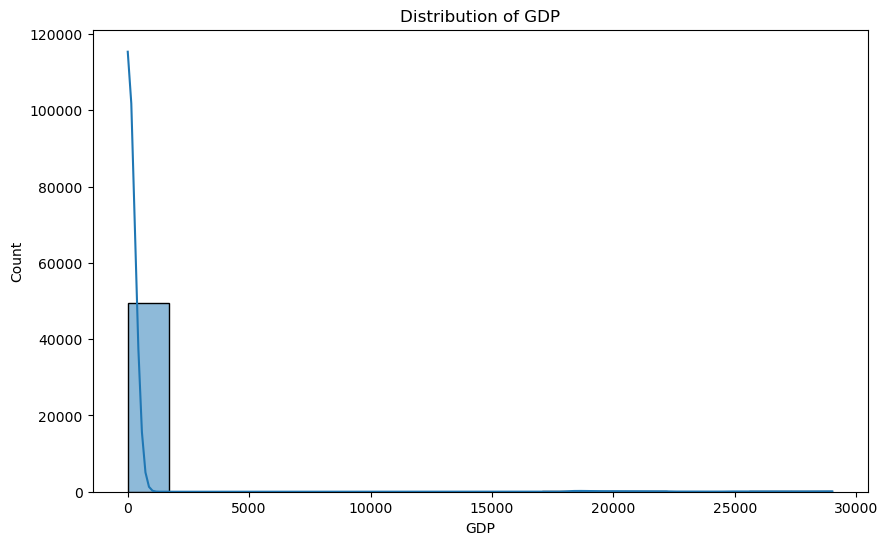

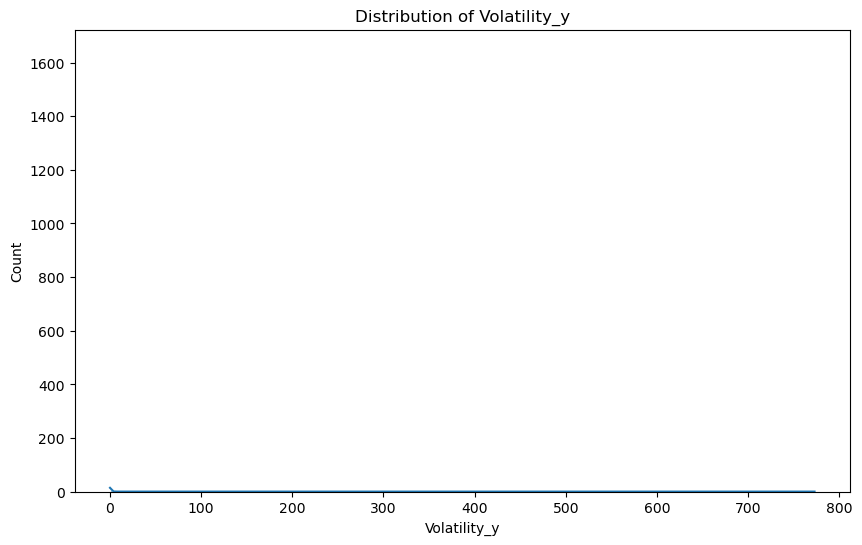

In [9]:
# Visualize distributions of key numerical features
numerical_features = ['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'PPIACO', 'CPIAUCSL', 'GDP', 'Volatility_y']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(combined_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

In [10]:
# Apply log transformation to reduce skewness
skewed_features = ['Volume_x', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'GDP', 'PPIACO', 'CPIAUCSL', 'Volatility_y']
for feature in skewed_features:
    combined_data[feature] = np.log1p(combined_data[feature])


In [11]:
# Select numeric columns to scale
numeric_features = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform the features
combined_data[numeric_features] = scaler.fit_transform(combined_data[numeric_features])



In [12]:
# Cap extreme outliers at the 99th percentile
for feature in skewed_features:
    cap = combined_data[feature].quantile(0.99)
    combined_data[feature] = np.where(combined_data[feature] > cap, cap, combined_data[feature])


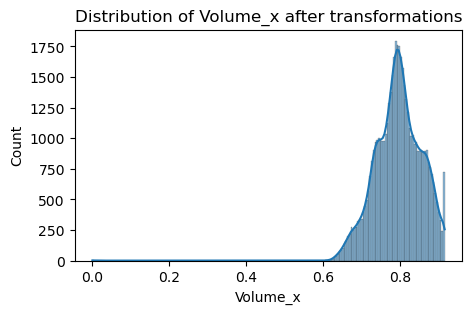

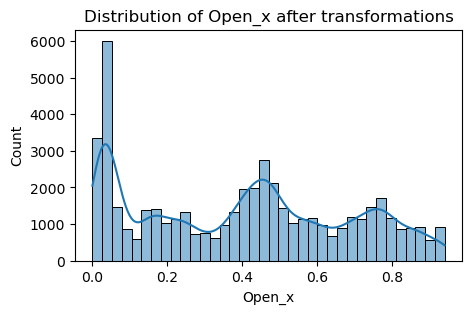

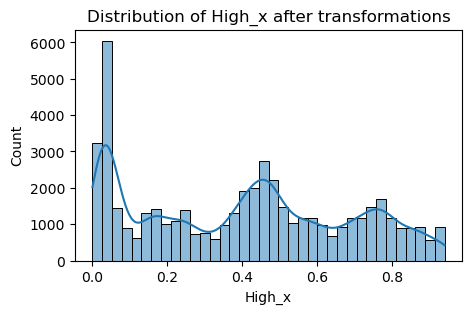

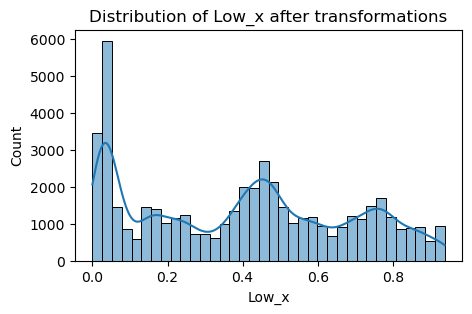

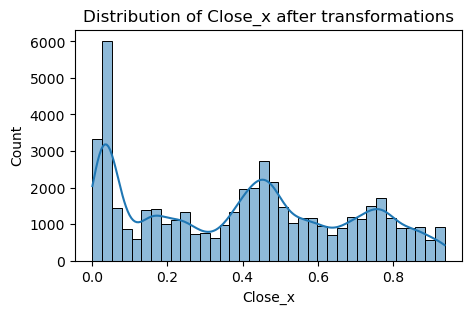

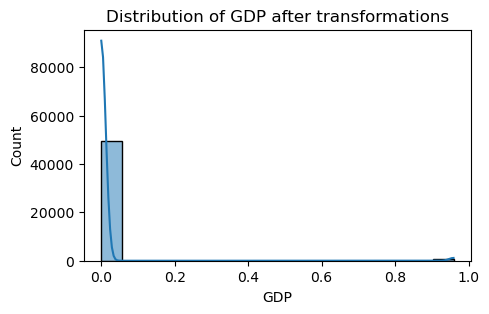

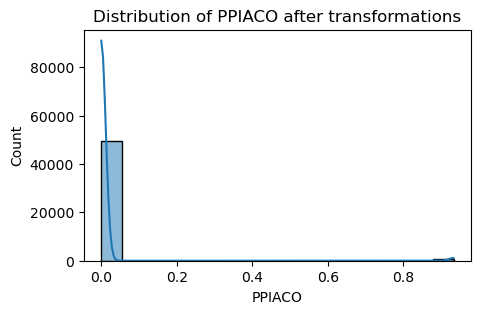

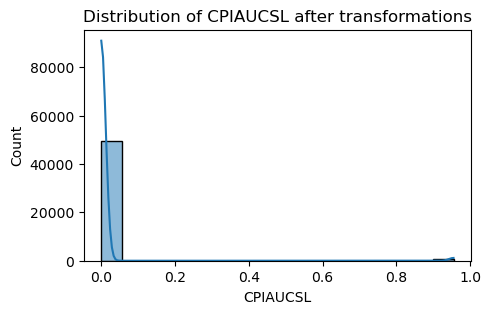

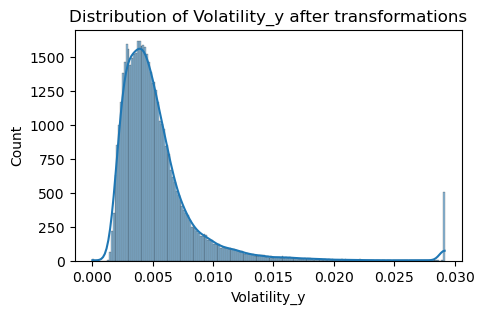

In [13]:
# Recheck distributions after log transformation, capping, and scaling
for feature in skewed_features:
    plt.figure(figsize=(5, 3,))
    sns.histplot(combined_data[feature], kde=True)
    plt.title(f'Distribution of {feature} after transformations')
    plt.show()

In [14]:
# Check skewness and kurtosis after transformation
for feature in skewed_features:
    skewness = combined_data[feature].skew()
    kurtosis = combined_data[feature].kurt()
    print(f'{feature} - Skewness: {skewness}, Kurtosis: {kurtosis}')


Volume_x - Skewness: -0.3995504820614711, Kurtosis: 2.7799074195332434
Open_x - Skewness: 0.13856307233230447, Kurtosis: -1.1869211321800068
High_x - Skewness: 0.1363466237098206, Kurtosis: -1.185493074989619
Low_x - Skewness: 0.1408028634881956, Kurtosis: -1.1885627154637068
Close_x - Skewness: 0.13848861195031673, Kurtosis: -1.1870047504510022
GDP - Skewness: 8.784729685902535, Kurtosis: 75.1746067252155
PPIACO - Skewness: 8.784778558510267, Kurtosis: 75.17575622770272
CPIAUCSL - Skewness: 8.784731715934987, Kurtosis: 75.17465454981995
Volatility_y - Skewness: 3.6062788192029505, Kurtosis: 17.956727939100816


In [15]:
# Check for missing values
missing_values = combined_data.isna().sum()
print("Missing Values after transformation:\n", missing_values[missing_values > 0])


Missing Values after transformation:
 Series([], dtype: int64)


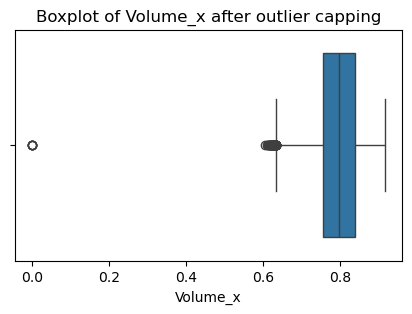

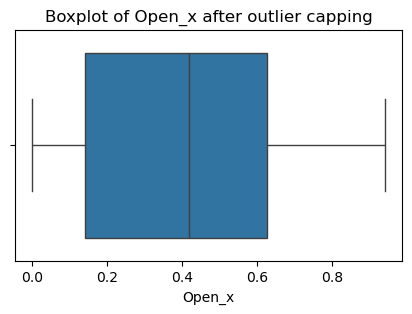

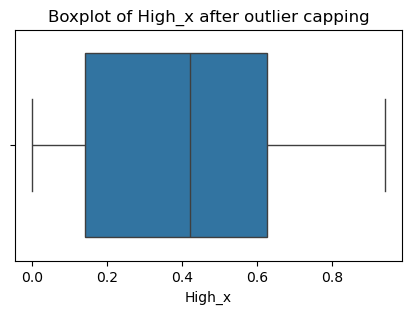

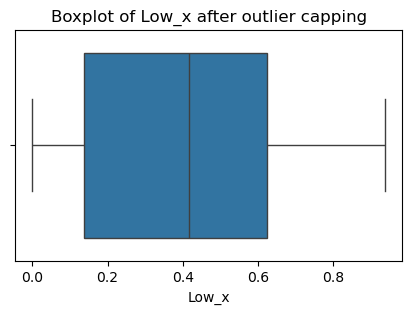

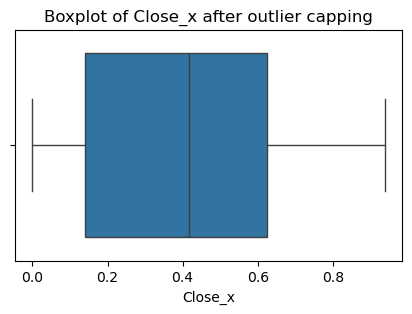

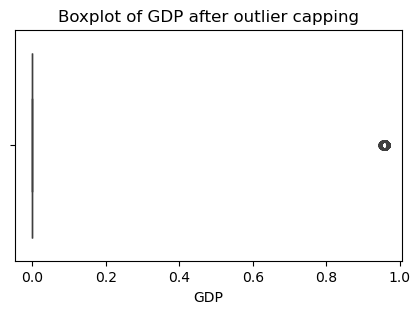

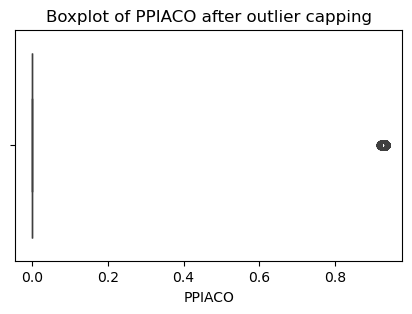

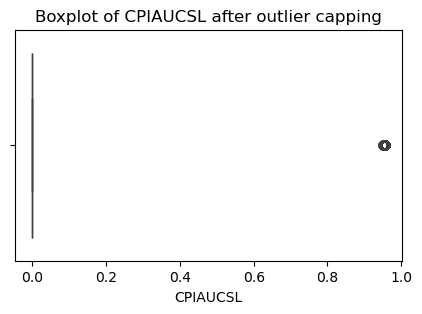

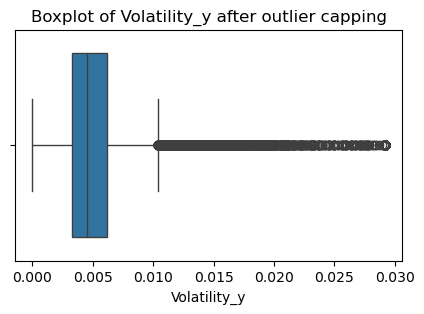

In [16]:
# Inspect potential outliers after capping
for feature in skewed_features:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=combined_data[feature])
    plt.title(f'Boxplot of {feature} after outlier capping')
    plt.show()

In [17]:
# Further transformation

# Apply log1p and/or Box-Cox for heavily skewed features
combined_data['GDP'] = np.log1p(combined_data['GDP'])
combined_data['PPIACO'] = np.log1p(combined_data['PPIACO'])
combined_data['CPIAUCSL'] = np.log1p(combined_data['CPIAUCSL'])

# For Volatility_y, you could try a Box-Cox transformation
# Ensure the data is positive for Box-Cox transformation
combined_data['Volatility_y'] = combined_data['Volatility_y'].replace(0, combined_data['Volatility_y'].mean())  # Replace zeros
combined_data['Volatility_y'], _ = boxcox(combined_data['Volatility_y'])


In [18]:
# Recheck skewness and kurtosis after transformation
for feature in skewed_features:
    skewness = combined_data[feature].skew()
    kurtosis = combined_data[feature].kurt()
    print(f'{feature} - Skewness: {skewness}, Kurtosis: {kurtosis}')

Volume_x - Skewness: -0.3995504820614711, Kurtosis: 2.7799074195332434
Open_x - Skewness: 0.13856307233230447, Kurtosis: -1.1869211321800068
High_x - Skewness: 0.1363466237098206, Kurtosis: -1.185493074989619
Low_x - Skewness: 0.1408028634881956, Kurtosis: -1.1885627154637068
Close_x - Skewness: 0.13848861195031673, Kurtosis: -1.1870047504510022
GDP - Skewness: 8.784719886369064, Kurtosis: 75.17437596327348
PPIACO - Skewness: 8.784746375800287, Kurtosis: 75.17499940393722
CPIAUCSL - Skewness: 8.784720986206564, Kurtosis: 75.17440187903885
Volatility_y - Skewness: -0.006910511970715722, Kurtosis: 0.0705475703048335


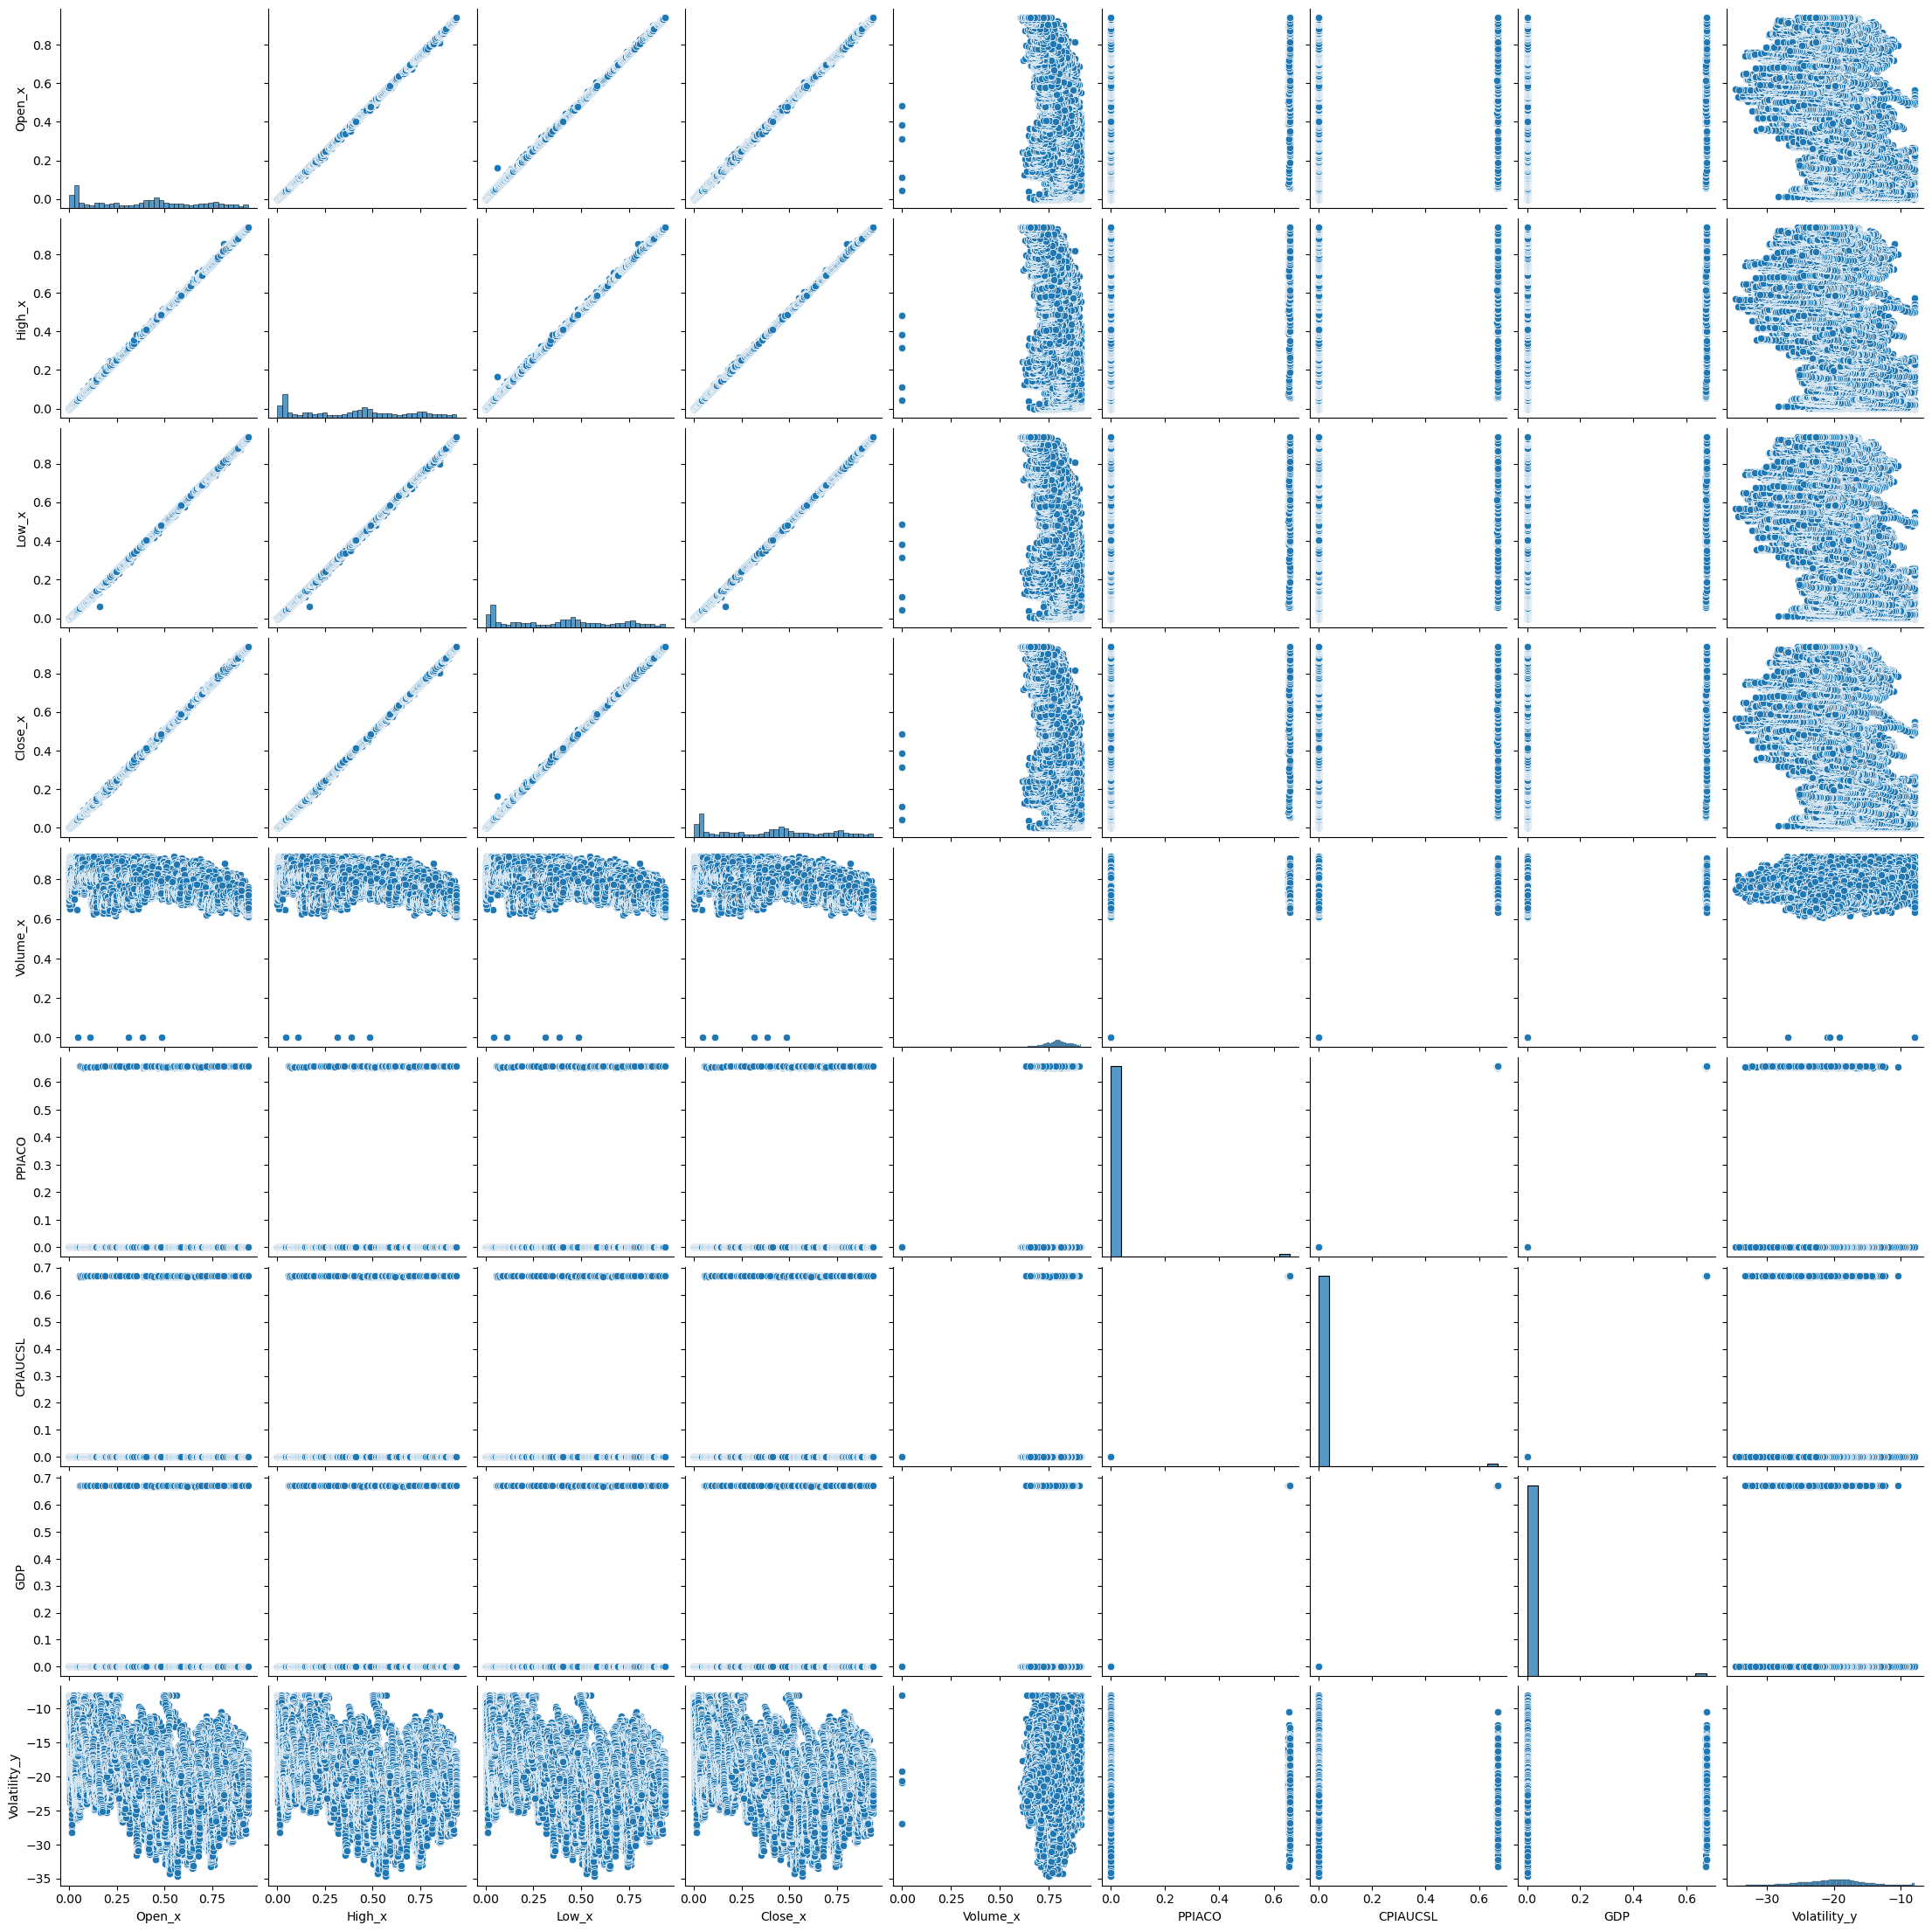

In [19]:
# Pairplot to understand relationships between key features
sns.pairplot(combined_data[numerical_features])
plt.show()

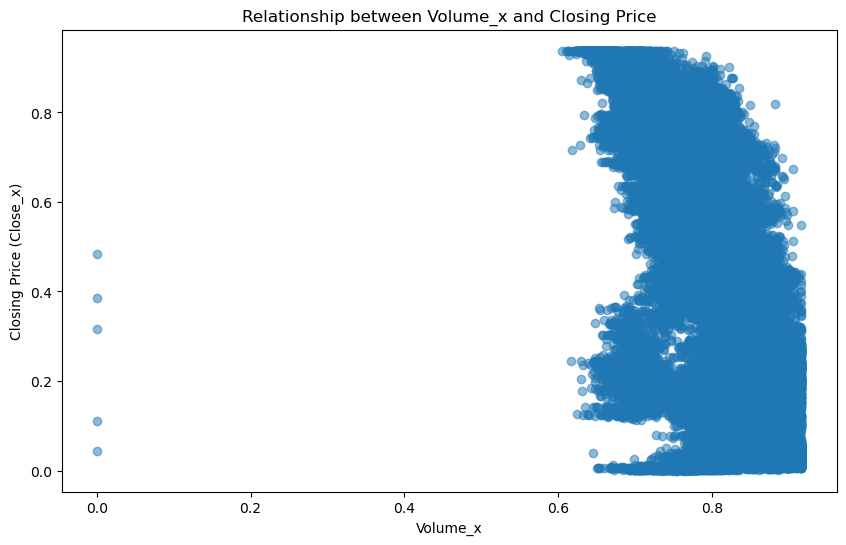

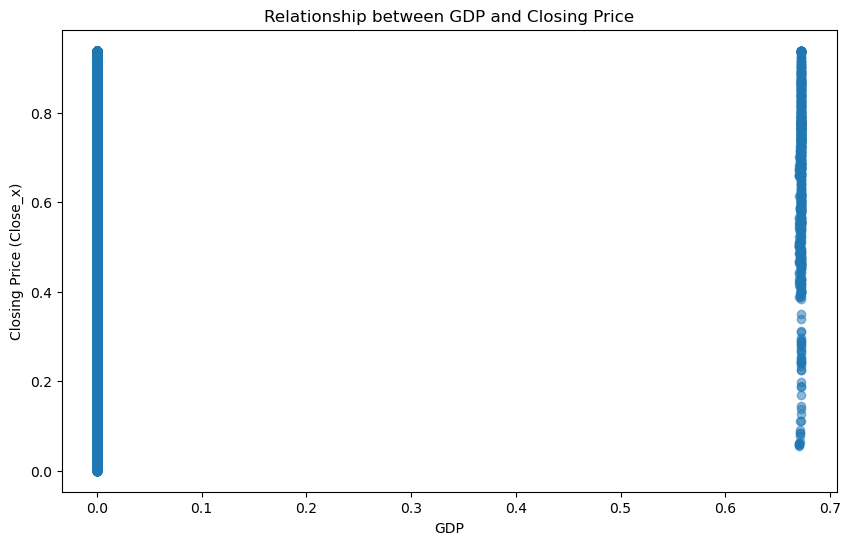

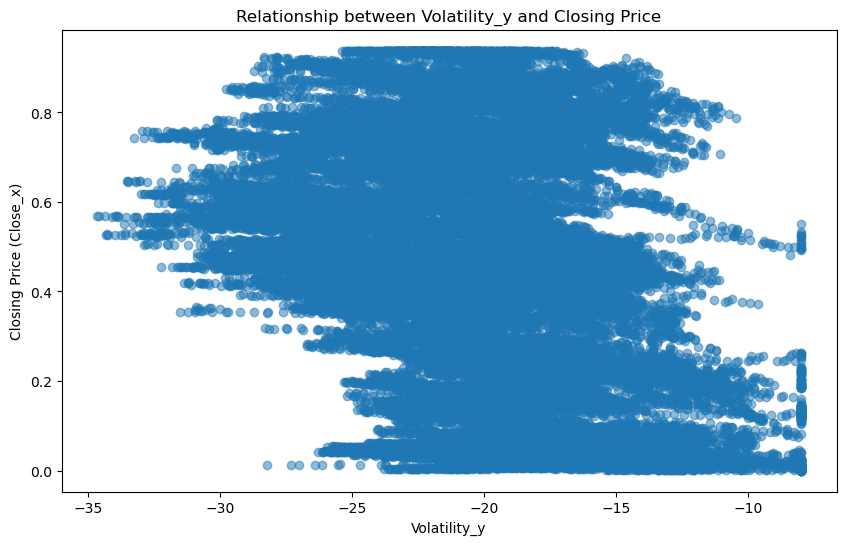

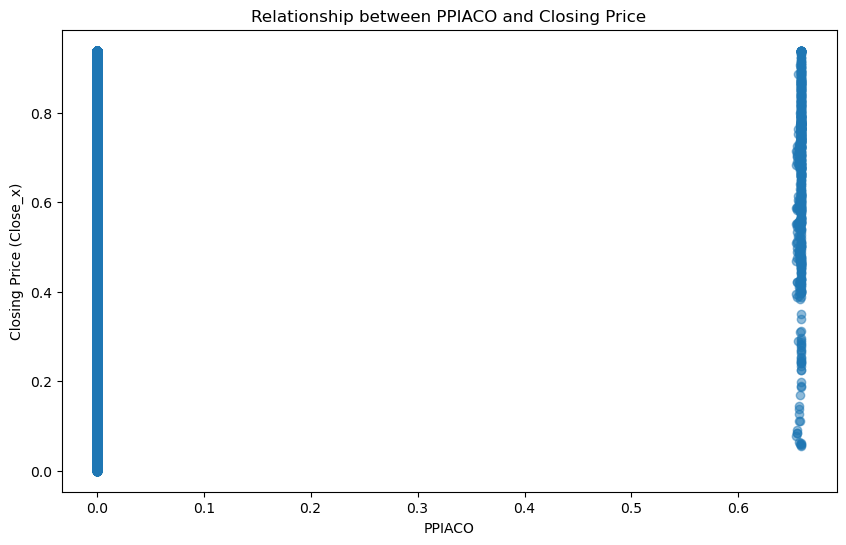

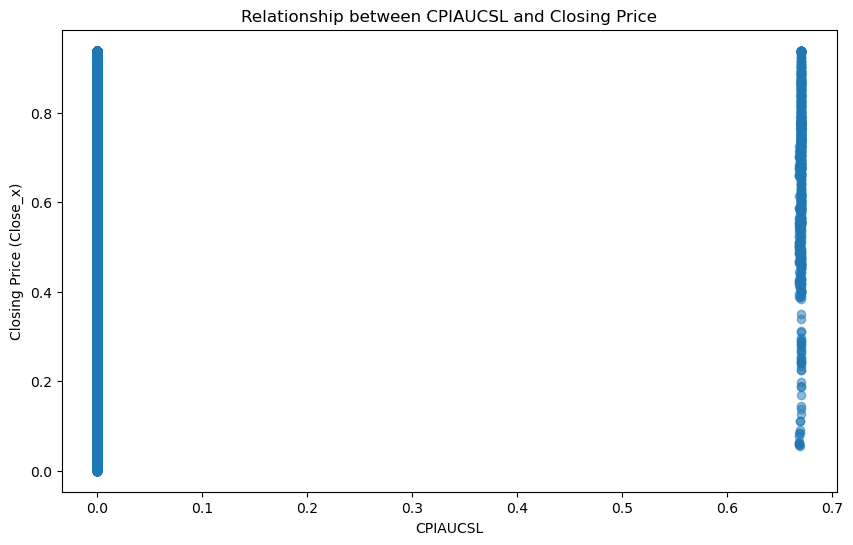

In [20]:
# Scatter plots to understand relationships between features and the target ('Close_x')
important_features = ['Volume_x', 'GDP', 'Volatility_y', 'PPIACO', 'CPIAUCSL']
for feature in important_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(combined_data[feature], combined_data['Close_x'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Closing Price (Close_x)')
    plt.title(f'Relationship between {feature} and Closing Price')
    plt.show()

# 5. Data process

In [21]:
# Removing features with high correlation (above 0.9) to reduce multicollinearity
corr_threshold = 0.9
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]
selected_features = combined_data.drop(columns=drop_columns + ['Date', 'Symbol', 'Close'])
labels = combined_data['Close']

In [22]:
# Feature selection using RandomForest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(selected_features, labels)
feature_importances = pd.Series(rf.feature_importances_, index=selected_features.columns)
important_features = feature_importances[feature_importances > 0.01].index
selected_features = selected_features[important_features]

In [23]:
# Scaling selected features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(selected_features)

In [24]:
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=0.95)  # Retain 95% of the variance
pca_features = pca.fit_transform(scaled_features)

# 6. Train-Test Split and Scaling

In [25]:
# Split data into training and testing sets
train_size = int(len(pca_features) * 0.8)
X_train, X_test = pca_features[:train_size], pca_features[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

In [26]:
# Reshape data for CNN-LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 7. Create Model

In [27]:
# Hyperparameter Tuning with Keras Tuner
# Define the model building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Choice('kernel_size', values=[1, 2, 3]), 
                     activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Reshape((1, 64)))
    model.add(Bidirectional(LSTM(hp.Int('units', min_value=32, max_value=128, step=32), activation='relu', return_sequences=True)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(hp.Int('units', min_value=32, max_value=128, step=32), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [ ]:
# Creat a hybrid CNN-LSTM model with Bidirectional LSTMs
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Reshape((1, 64)))
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting
model.add(LSTM(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # Add L2 regularization
model.add(Dropout(0.3))  # Add another dropout layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 8. Train Model

In [ ]:
# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

In [30]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping, lr_reduction])

Epoch 1/50
1251/1251 - 36s - loss: 0.0459 - mae: 0.0180 - val_loss: 0.0031 - val_mae: 0.0208 - lr: 0.0010 - 36s/epoch - 29ms/step
Epoch 2/50
1251/1251 - 26s - loss: 0.0012 - mae: 0.0168 - val_loss: 0.0028 - val_mae: 0.0186 - lr: 0.0010 - 26s/epoch - 21ms/step
Epoch 3/50
1251/1251 - 31s - loss: 0.0010 - mae: 0.0154 - val_loss: 0.0023 - val_mae: 0.0206 - lr: 0.0010 - 31s/epoch - 25ms/step
Epoch 4/50
1251/1251 - 40s - loss: 9.6481e-04 - mae: 0.0149 - val_loss: 0.0024 - val_mae: 0.0168 - lr: 0.0010 - 40s/epoch - 32ms/step
Epoch 5/50
1251/1251 - 38s - loss: 8.9791e-04 - mae: 0.0144 - val_loss: 0.0015 - val_mae: 0.0139 - lr: 0.0010 - 38s/epoch - 30ms/step
Epoch 6/50
1251/1251 - 44s - loss: 8.4909e-04 - mae: 0.0140 - val_loss: 0.0057 - val_mae: 0.0357 - lr: 0.0010 - 44s/epoch - 35ms/step
Epoch 7/50
1251/1251 - 45s - loss: 8.8775e-04 - mae: 0.0143 - val_loss: 0.0020 - val_mae: 0.0178 - lr: 0.0010 - 45s/epoch - 36ms/step
Epoch 8/50
1251/1251 - 39s - loss: 8.5539e-04 - mae: 0.0143 - val_loss: 0.

# 9. Evaluate Model

In [31]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Test Loss: 0.0015146515797823668, Test MAE: 0.013923315331339836


# 10. Visualize Model

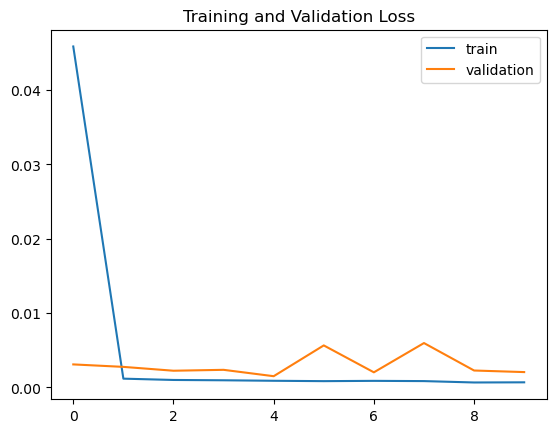

In [32]:
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 11. Make Predictions

313/313 [==============================] - 1s 3ms/step


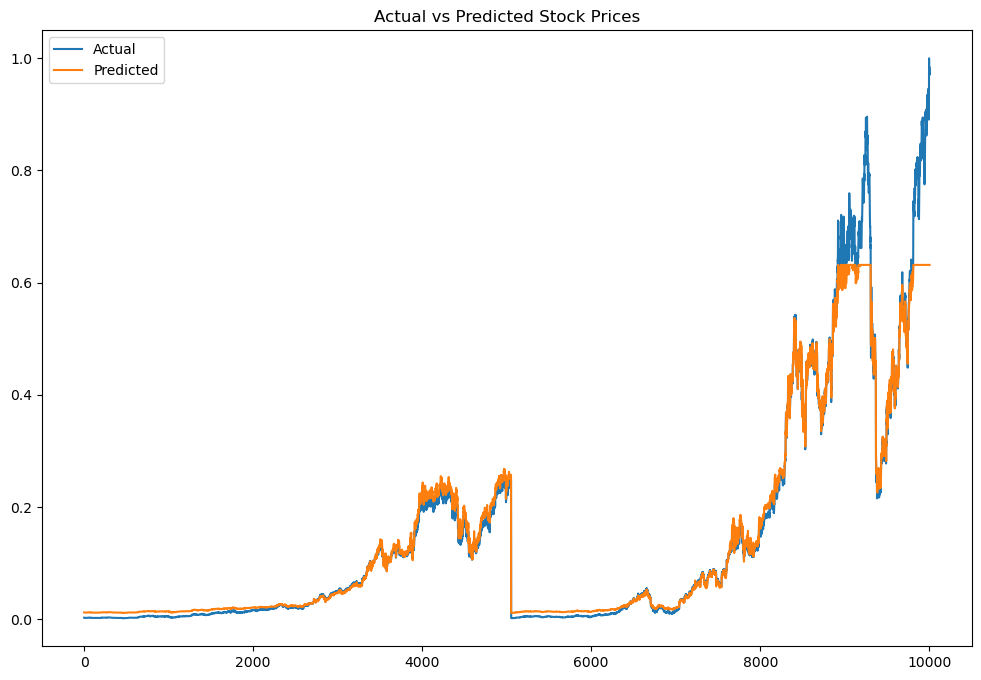

In [37]:
# Make predictions
y_pred = model.predict(X_test)
plt.figure(figsize=(12, 8))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.show()

# 12. Evaluation Metrics

In [35]:
# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 0.03634340589663492
MAPE: 0.7254352378191489


# 13. Backtesting

In [ ]:
# Backtesting (Placeholder)
# Implement backtesting logic to simulate model performance in a trading scenario
print("Backtesting results")
